In [1]:
# Import package yang dibutuhkan
import os
import numpy as np
import pandas as pd
import pathlib 
import matplotlib.pyplot as plt
import random
from shutil import copyfile

import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras import layers

## **Explore isi folder dataset**

In [5]:
# Cek path dataset
isi = []
for dirname, _, filenames in os.walk('./PetImages/'):
    for filename in filenames:
        isi.append(os.path.join(dirname, filename))

isi[:5]

['./PetImages/Cat\\0.jpg',
 './PetImages/Cat\\1.jpg',
 './PetImages/Cat\\10.jpg',
 './PetImages/Cat\\100.jpg',
 './PetImages/Cat\\1000.jpg']

Jangan lupa menghapus file gambar yang sizenya terlalu kecil

Jumlah class

In [7]:
# Mengecek jumlah class
jumlahKelas = len(os.listdir("./PetImages/"))
jumlahKelas

2

Nama class

In [15]:
data_dir = pathlib.Path("./PetImages/")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) 
print(class_names)

['Cat' 'Dog']


Isi class

In [6]:
# Mengecek jumlah item pada setiap class
for dirpath, dirnames, filenames in os.walk("./PetImages/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in ./PetImages/
There are 0 directories and 12186 images in ./PetImages/Cat
There are 0 directories and 12213 images in ./PetImages/Dog


## **Split Dataset untuk Training, Validation, dan Testing**

In [24]:
# Fungsi untuk splitting dataset
def split_data(main_dir, training_dir, validation_dir, test_dir = None, include_test_split = True, split_size=0.8):
    files = []

    for file in os.listdir(main_dir):
        if os.path.getsize(os.path.join(main_dir, file)): 
            files.append(file) 

    shuffled_files = random.sample(files, len(files))
    # Alokasi persentase dataset untuk training 
    split = int(split_size * len(shuffled_files))
    # Mengambil data untuk training
    train = shuffled_files[:split]
    # Alokasi persentase dataset untuk validation dan testing 
    split_valid_test = int(split + (len(shuffled_files)-split)/1.5)

    if include_test_split:
        # Mengambil data untuk validation
        validation = shuffled_files[split:split_valid_test] 
        # Mengambil data untuk testing
        test = shuffled_files[split_valid_test:]
    else:
        # Hanya mengambil data untuk validation jika tidak melakukan testing
        validation = shuffled_files[split:]
    
    # Copy data ke folder baru agar terbagi menjadi training, validation, dan testing
    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) 

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))
        
    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element))

    print("Split sucessful!")

In [28]:
# Melakukan splitting data
split_data("./PetImages/Cat/", "./data/train/Cat/", "./data/validation/Cat/", "./data/test/Cat/", include_test_split=True, split_size=0.8)
split_data("./PetImages/Dog/", "./data/train/Dog/", "./data/validation/Dog/", "./data/test/Dog/", include_test_split=True, split_size=0.8)

Split sucessful!
Split sucessful!


Mengecek jumlah image pada data training, validation, dan test

In [29]:
print(len(os.listdir("./data/train/Cat/")))
print(len(os.listdir("./data/train/Dog/")))

print(len(os.listdir("./data/validation/Cat/")))
print(len(os.listdir("./data/validation/Dog/")))

print(len(os.listdir("./data/test/Cat/")))
print(len(os.listdir("./data/test/Dog/")))

9748
9770
1625
1628
813
815


Mendefinisikan path data train, validation, dan test

In [3]:
train_dir = "./data/train/"
validation_dir = "./data/validation/"
test_dir = "./data/test/"

## **Memvisualisasikan random image**

In [3]:
def plot_random_image(target_dir):
    target_class = random.choice(os.listdir(target_dir))
    target_folder = os.path.join(target_dir,target_class)
    random_image = random.sample(os.listdir(target_folder), 5)

    plt.figure(figsize=(16,5))
    for i in range(5):
        plt.subplot(1,5,i+1)
        img = tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img = tf.io.decode_image(img)
        plt.imshow(img)
        plt.title(f'{target_class}\n{img.shape}')
        plt.axis(False) 

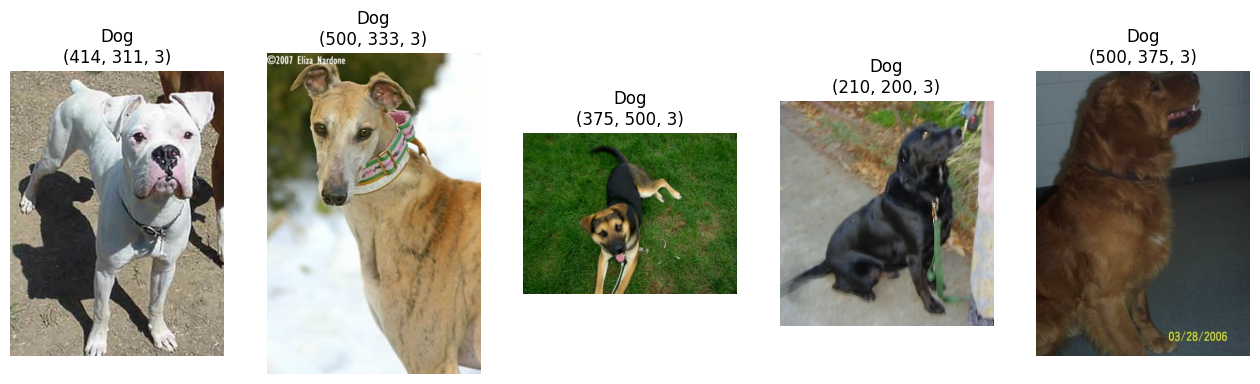

In [4]:
# Plot random image dari folder training
plot_random_image(train_dir)

## **Mengolah Data**

In [4]:
# Normalisasi nilai pixel agar ada di antara 0 dan 1
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
# Menyeragamkan ukuran gambar dan mengatur batch size
train_data = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = "binary",
)

valid_data = valid_datagen.flow_from_directory(
    directory = validation_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = "binary",
)

test_data = test_datagen.flow_from_directory(
    directory = test_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = "binary",
)

Found 19516 images belonging to 2 classes.
Found 3253 images belonging to 2 classes.
Found 1628 images belonging to 2 classes.


## **Model CNN**

In [6]:
inputs5 = layers.Input(shape=(224,224,3))

x = Conv2D(32, (3,3), activation='relu')(inputs5)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(256, (3,3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(2, activation='softmax')(x) 

model5 = Model(inputs=inputs5, outputs=x)

In [7]:
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [8]:
model5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856 

Mengatur early stopping agar tidak terjadi overfitting

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Fitting model dengan 30 epoch

In [ ]:
hist5 = model5.fit(
    train_data,
    epochs = 30,
    validation_data = valid_data,
    callbacks=[early_stopping]
)

Epoch 1/30
147/610 [======>.......................] - ETA: 2:37 - loss: 0.6932 - accuracy: 0.4951

c:\Users\Nando\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


610/610 [==============================] - 260s 400ms/step - loss: 0.6888 - accuracy: 0.5208 - val_loss: 0.7288 - val_accuracy: 0.5712
Epoch 2/30
610/610 [==============================] - 87s 143ms/step - loss: 0.6615 - accuracy: 0.5942 - val_loss: 0.6190 - val_accuracy: 0.6741
Epoch 3/30
610/610 [==============================] - 79s 129ms/step - loss: 0.6019 - accuracy: 0.6803 - val_loss: 0.6126 - val_accuracy: 0.6726
Epoch 4/30
610/610 [==============================] - 86s 141ms/step - loss: 0.5388 - accuracy: 0.7362 - val_loss: 0.5022 - val_accuracy: 0.7498
Epoch 5/30
610/610 [==============================] - 75s 123ms/step - loss: 0.4812 - accuracy: 0.7736 - val_loss: 0.4424 - val_accuracy: 0.7876
Epoch 6/30
610/610 [==============================] - 67s 109ms/step - loss: 0.4030 - accuracy: 0.8208 - val_loss: 0.3646 - val_accuracy: 0.8401
Epoch 7/30
610/610 [==============================] - 67s 109ms/step - loss: 0.3421 - accuracy: 0.8531 - val_loss: 0.3488 - val_accuracy: 0.

Tampak bahwa akurasinya mencapai 91% untuk data validation

Evaluate data menggunakan data test

In [10]:
result5 = model5.evaluate(test_data)
result5

51/51 [==============================] - 16s 327ms/step - loss: 0.2251 - accuracy: 0.9140


[0.22512638568878174, 0.914004921913147]

Tampak bahwa akurasinya mencapai 91% untuk data test

Menampilkan epoch terbaik berdasarkan akurasi data validation

In [18]:
val_acc_per_epoch = hist5.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Epoch terbaik untuk akurasi: %d' % (best_epoch,))

Epoch terbaik untuk akurasi: 13


Menampilkan epoch terbaik berdasarkan loss data validation

In [20]:
best_epoch = early_stopping.stopped_epoch - early_stopping.patience
print('Epoch terbaik untuk loss:', best_epoch)

Epoch terbaik untuk loss: 12


In [15]:
def plot_loss_accuracy(history):

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize = (20,7))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label = "Training Loss")
    plt.plot(epochs, val_loss, label = "Validation Loss")
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy, label = "Training Accuracy")
    plt.plot(epochs,val_accuracy, label = "Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

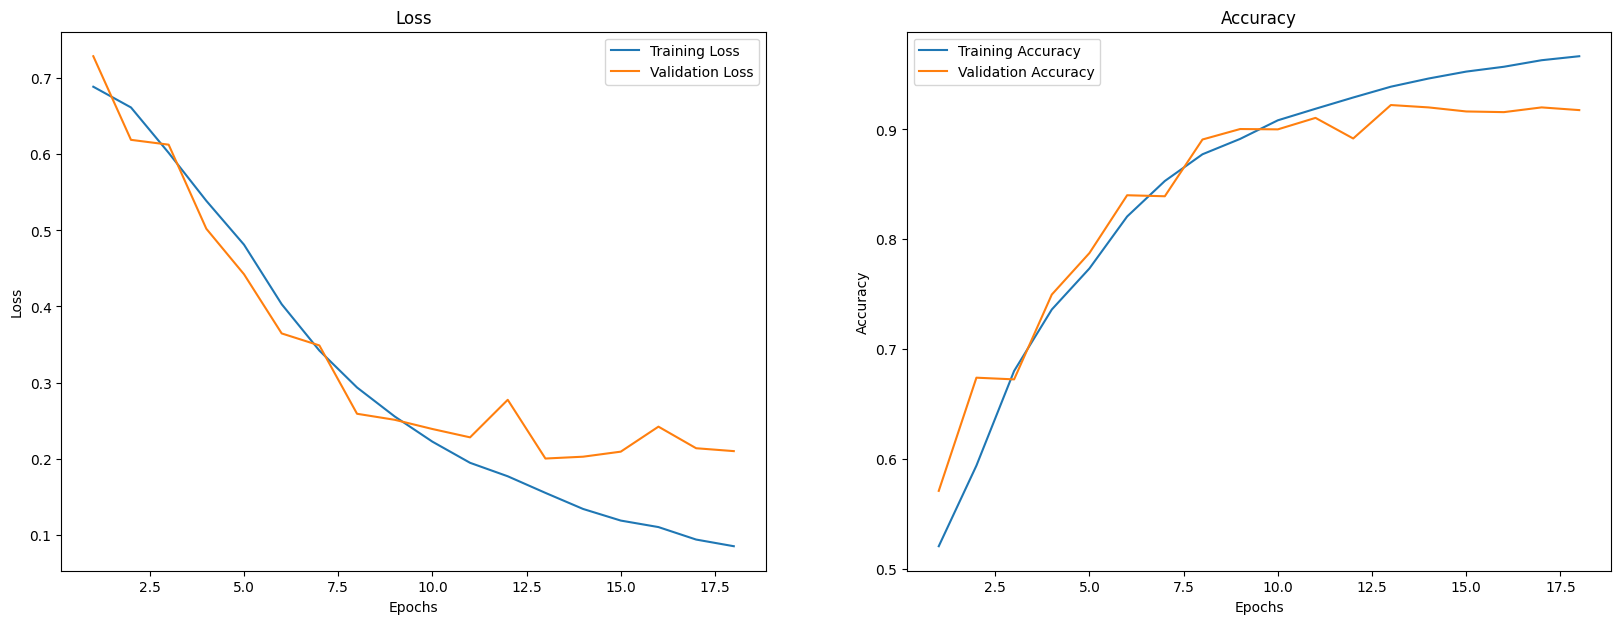

In [16]:
plot_loss_accuracy(hist5)

#### **Visualisasi Akurasi dan Lost pada data train dan data validation**

In [13]:
def plot_accuracy_lost(hist):
    plt.figure(figsize=(20, 14))

    # Plot Akurasi
    plt.subplot(2, 1, 1)
    i_train_acc = hist.history['accuracy']
    i_val_acc = hist.history['val_accuracy']
    i_epoch = [i for i in range(len(i_val_acc))]
    plt.plot(i_epoch , i_train_acc , 'go-' , label = 'Training Accuracy')
    plt.plot(i_epoch, i_val_acc , 'ro-' , label = 'Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    # Plot Loss
    plt.subplot(2, 1, 2)
    i_train_loss = hist.history['loss']
    i_val_loss = hist.history['val_loss']
    i_epoch = [i for i in range(len(i_val_acc))]
    plt.plot(i_epoch , i_train_loss , 'go-' , label = 'Training Loss')
    plt.plot(i_epoch , i_val_loss , 'ro-' , label = 'Validation Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()


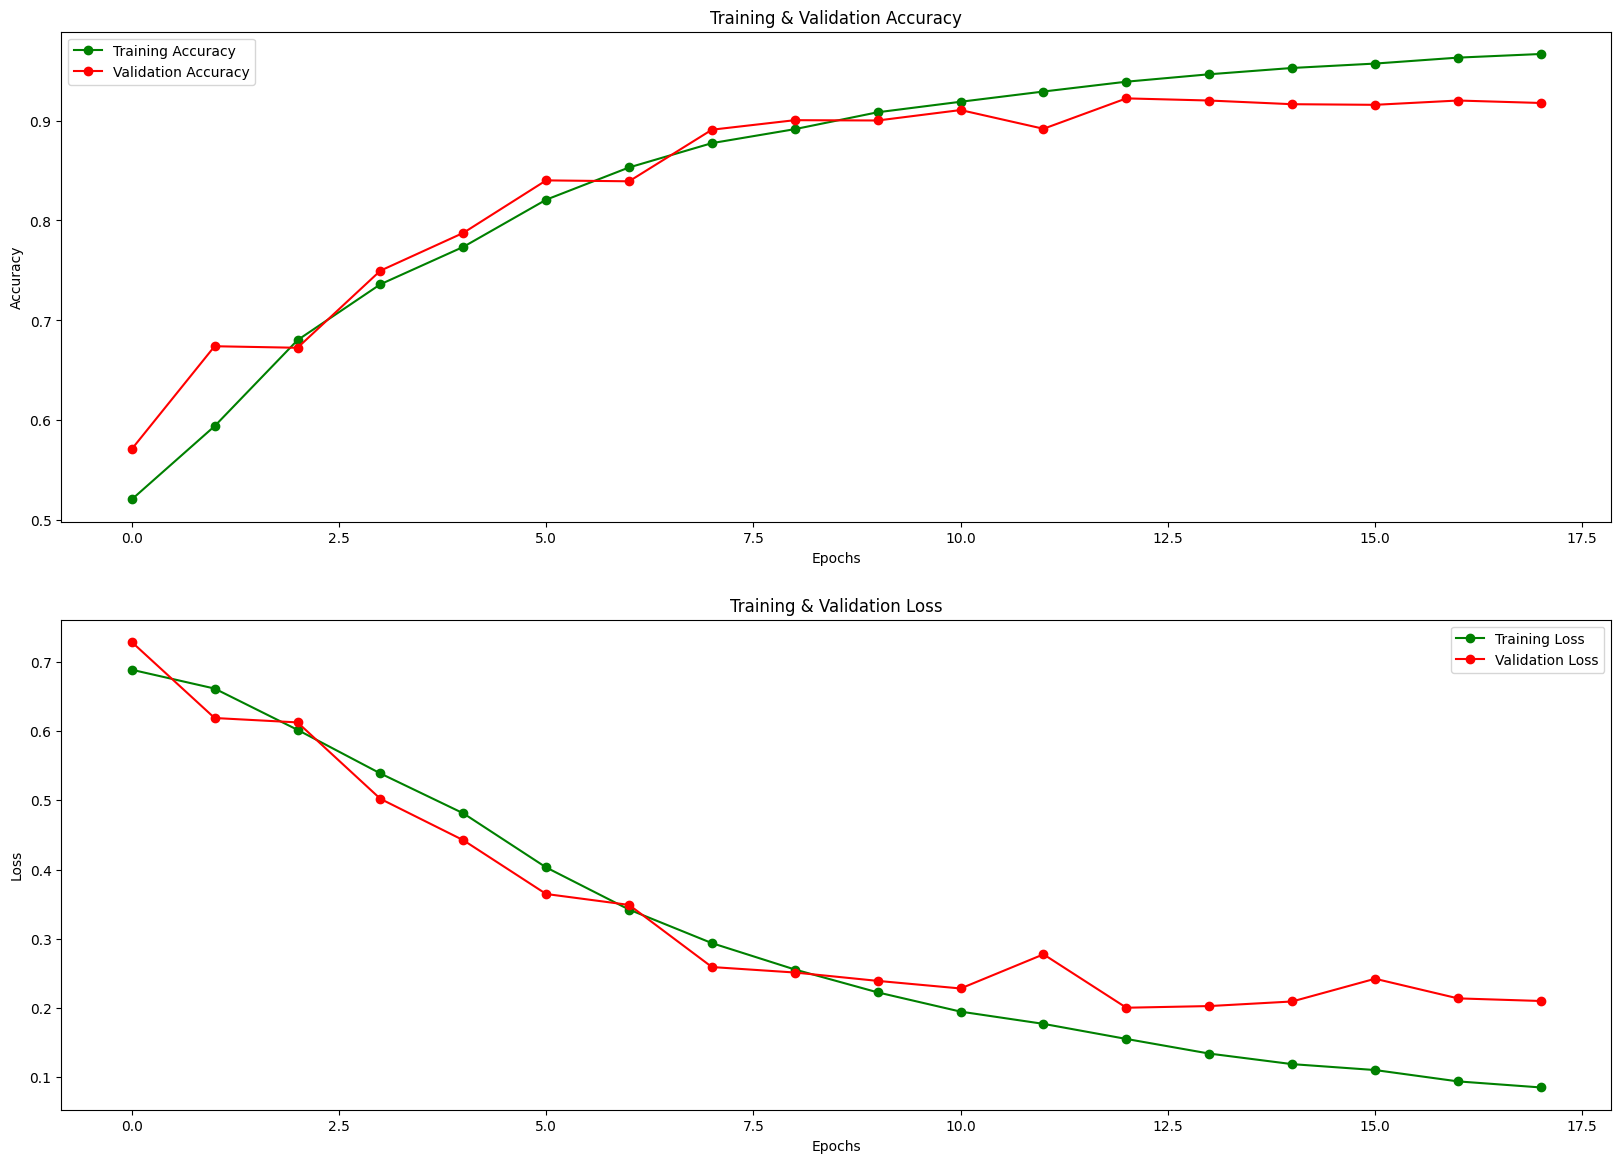

In [14]:
plot_accuracy_lost(hist5)

In [17]:
results_tabel = pd.DataFrame(hist5.history)
results_tabel.tail()

loss  accuracy  val_loss  val_accuracy
13  0.133973  0.946352  0.202644      0.920074
14  0.118715  0.952654  0.209272      0.916385
15  0.110170  0.957061  0.242124      0.915770
16  0.093775  0.963005  0.213764      0.920074
17  0.085015  0.966643  0.209976      0.917615

#### **Menampilkan gambar dan label hasil prediksi**

In [13]:
def plot_prediction(model_n, generator, n_images):
    i = 1
    images, labels = generator.next()

    preds = model_n.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

1/1 [==============================] - 0s 47ms/step


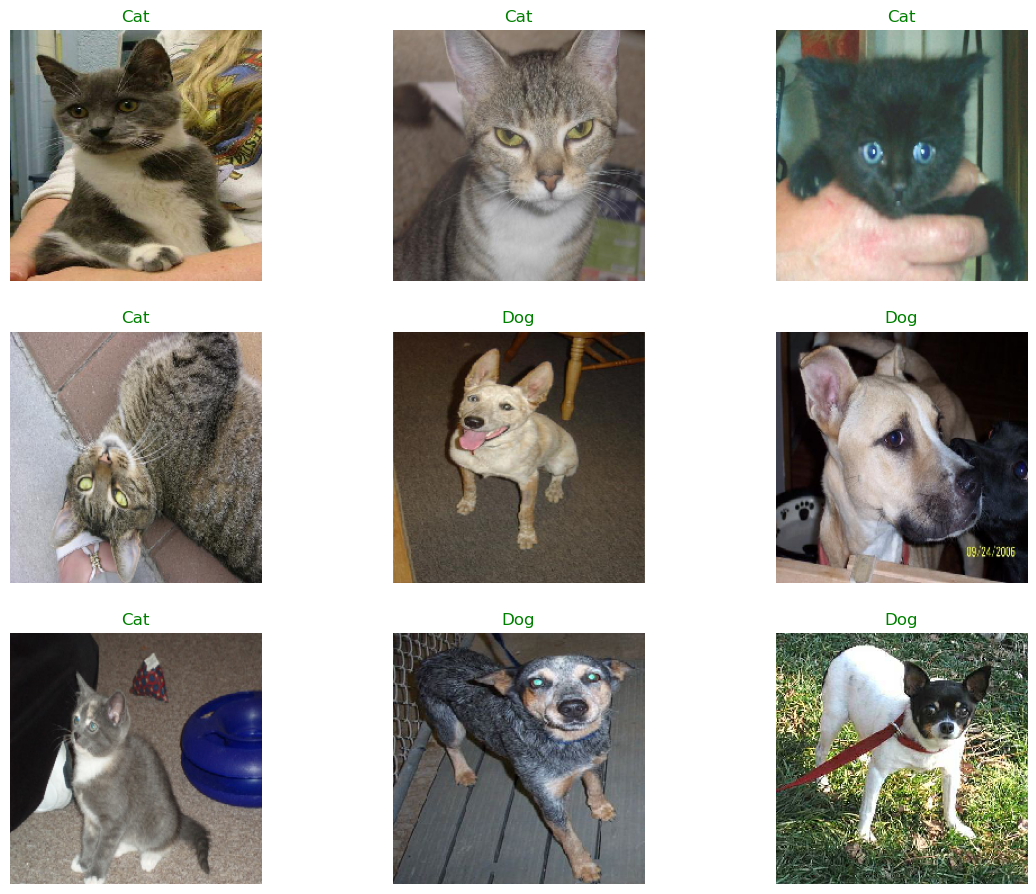

In [16]:
plot_prediction(model5, test_data, 10)

Tampak bahwa model berhasil memprediksi dengan benar

In [39]:
# Menyimpan model
model5.save(os.path.join("./models", "model5.h5"))

## **Model VGG16**

In [25]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layer
for layer in vgg.layers:
    layer.trainable = False

model7 = Sequential()
model7.add(vgg)
model7.add(Flatten())
model7.add(Dense(512, activation='relu'))
model7.add(Dense(2, activation='softmax'))

In [26]:
model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [27]:
model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               12845568  
                                                                 
 dense_8 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 27,561,282
Trainable params: 12,846,594
Non-trainable params: 14,714,688
_________________________________________________________________


In [28]:
hist7 = model7.fit(
    train_data,
    epochs = 30,
    validation_data = valid_data,
    callbacks=[early_stopping]
)

Epoch 1/30
610/610 [==============================] - 119s 194ms/step - loss: 0.3675 - accuracy: 0.8969 - val_loss: 0.1839 - val_accuracy: 0.9259
Epoch 2/30
610/610 [==============================] - 118s 194ms/step - loss: 0.1351 - accuracy: 0.9451 - val_loss: 0.2125 - val_accuracy: 0.9204
Epoch 3/30
610/610 [==============================] - 119s 195ms/step - loss: 0.0984 - accuracy: 0.9599 - val_loss: 0.2003 - val_accuracy: 0.9259
Epoch 4/30
610/610 [==============================] - 122s 200ms/step - loss: 0.0834 - accuracy: 0.9668 - val_loss: 0.2188 - val_accuracy: 0.9207
Epoch 5/30
610/610 [==============================] - 119s 194ms/step - loss: 0.0677 - accuracy: 0.9734 - val_loss: 0.1940 - val_accuracy: 0.9324
Epoch 6/30
610/610 [==============================] - 122s 200ms/step - loss: 0.0499 - accuracy: 0.9805 - val_loss: 0.2241 - val_accuracy: 0.9333


Tampak bahwa akurasinya mencapai 93.3% untuk data validation

In [38]:
result7 = model7.evaluate(test_data)
result7

51/51 [==============================] - 8s 160ms/step - loss: 0.1813 - accuracy: 0.9195


[0.18133293092250824, 0.9195331931114197]

Akurasinya juga mencapai 91.9% untuk data test

In [32]:
val_acc_per_epoch = hist7.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Epoch terbaik untuk akurasi: %d' % (best_epoch,))

Epoch terbaik untuk akurasi: 6


In [33]:
best_epoch = early_stopping.stopped_epoch - early_stopping.patience
print('Epoch terbaik untuk loss', best_epoch)

Epoch terbaik untuk loss 0


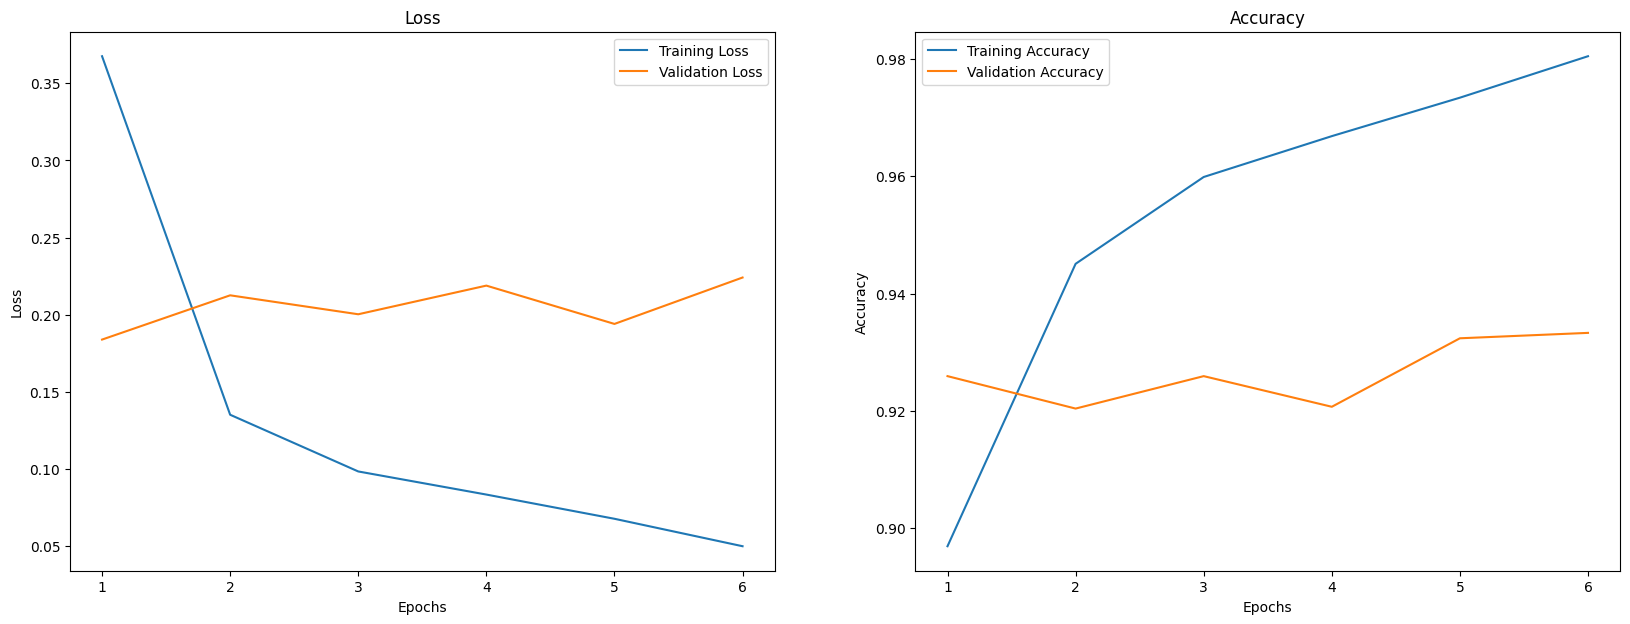

In [34]:
plot_loss_accuracy(hist7)

#### **Visualisasi Akurasi dan Lost pada data train dan data validation**

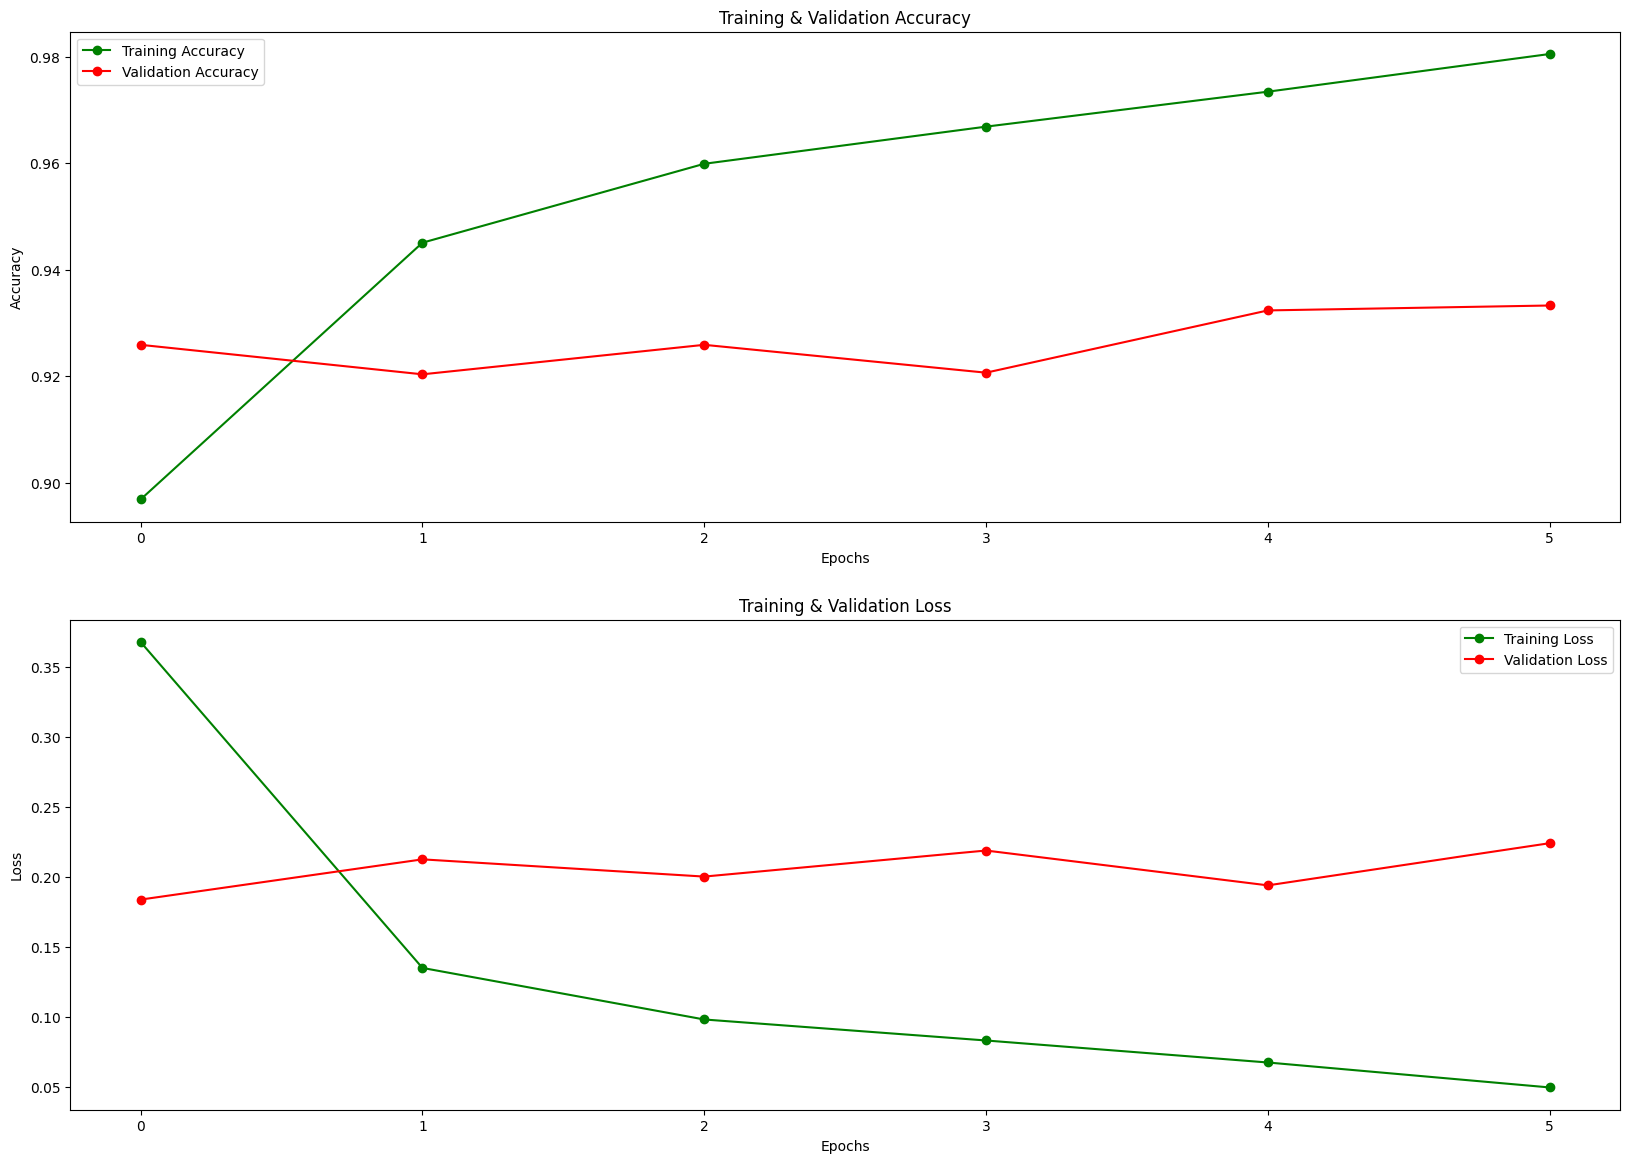

In [35]:
plot_accuracy_lost(hist7)

In [36]:
results_tabel = pd.DataFrame(hist7.history)
results_tabel.tail()

loss  accuracy  val_loss  val_accuracy
1  0.135129  0.945071  0.212545      0.920381
2  0.098369  0.959879  0.200261      0.925915
3  0.083389  0.966848  0.218835      0.920689
4  0.067695  0.973406  0.193999      0.932370
5  0.049903  0.980478  0.224079      0.933292

Melakukan prediksi

1/1 [==============================] - 0s 191ms/step


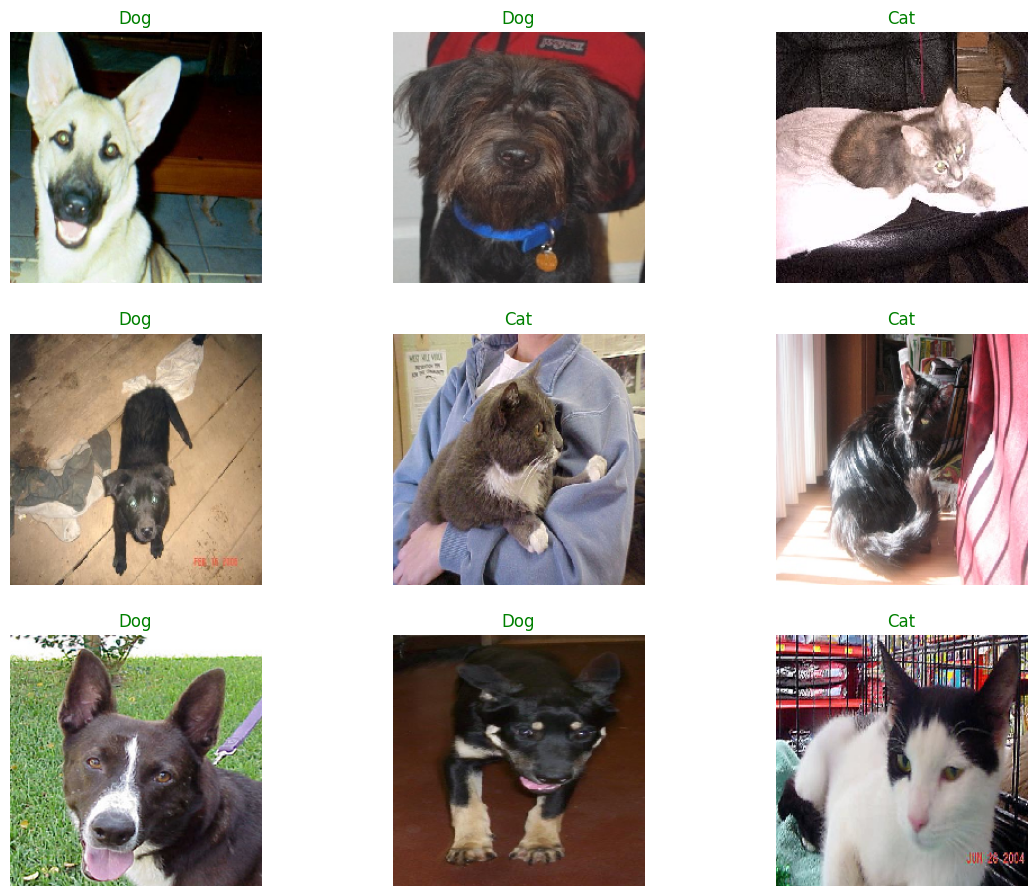

In [86]:
plot_prediction(model7, test_data, 10)

Tampak bahwa model berhasil memprediksi dengan benar

In [87]:
# Menyimpan model VGG
model7.save(os.path.join("./models", "vgg.h5"))

## **Model InceptionV3**

In [108]:
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layer
for layer in inception.layers:
    layer.trainable = False

model9 = Sequential()
model9.add(inception)
model9.add(Flatten())
model9.add(Dense(512, activation='relu'))
model9.add(Dense(10, activation='softmax'))

In [109]:
model9.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [110]:
model9.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 51200)             0         
                                                                 
 dense_39 (Dense)            (None, 512)               26214912  
                                                                 
 dense_40 (Dense)            (None, 10)                5130      
                                                                 
Total params: 48,022,826
Trainable params: 26,220,042
Non-trainable params: 21,802,784
_________________________________________________________________


In [111]:
hist9 = model9.fit(
    train_data,
    epochs = 6,
    validation_data = valid_data,
)

Epoch 1/6
429/610 [====================>.........] - ETA: 15s - loss: 1.5020 - accuracy: 0.9730

c:\Users\Nando\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


610/610 [==============================] - 67s 102ms/step - loss: 1.1918 - accuracy: 0.9758 - val_loss: 0.1081 - val_accuracy: 0.9880
Epoch 2/6
610/610 [==============================] - 63s 103ms/step - loss: 0.0595 - accuracy: 0.9922 - val_loss: 0.0561 - val_accuracy: 0.9883
Epoch 3/6
610/610 [==============================] - 63s 103ms/step - loss: 0.0127 - accuracy: 0.9955 - val_loss: 0.0529 - val_accuracy: 0.9889
Epoch 4/6
610/610 [==============================] - 63s 103ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.0403 - val_accuracy: 0.9883
Epoch 5/6
610/610 [==============================] - 65s 107ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0631 - val_accuracy: 0.9877
Epoch 6/6
610/610 [==============================] - 65s 107ms/step - loss: 6.5026e-04 - accuracy: 0.9998 - val_loss: 0.0573 - val_accuracy: 0.9886


Tampak bahwa akurasinya sangat bagus, yaitu 99.9% untuk data train dan 98.8% untuk data validation

In [112]:
result9 = model9.evaluate(test_data)
result9

51/51 [==============================] - 5s 88ms/step - loss: 0.0659 - accuracy: 0.9883


[0.06592096388339996, 0.9883292317390442]

Akurasi pada data test pun juga mencapai 98.8%

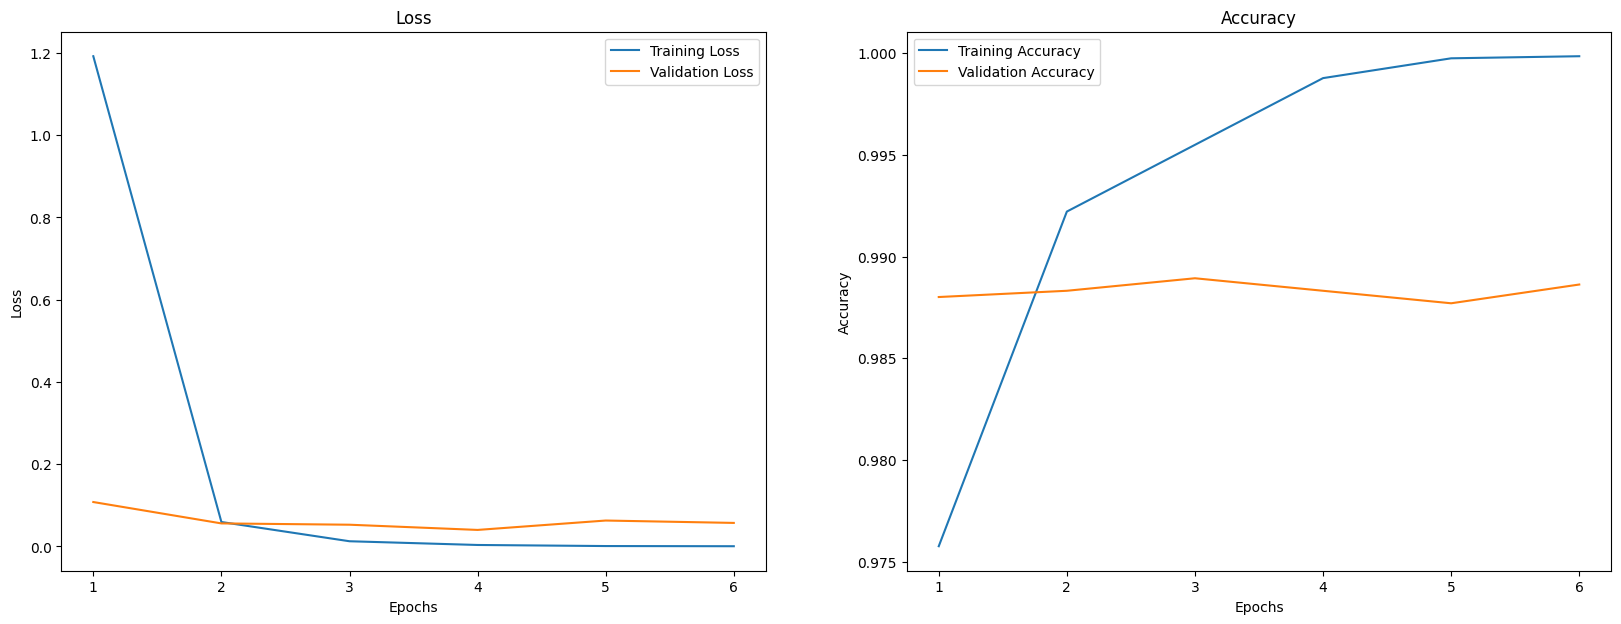

In [113]:
plot_loss_accuracy(hist9)

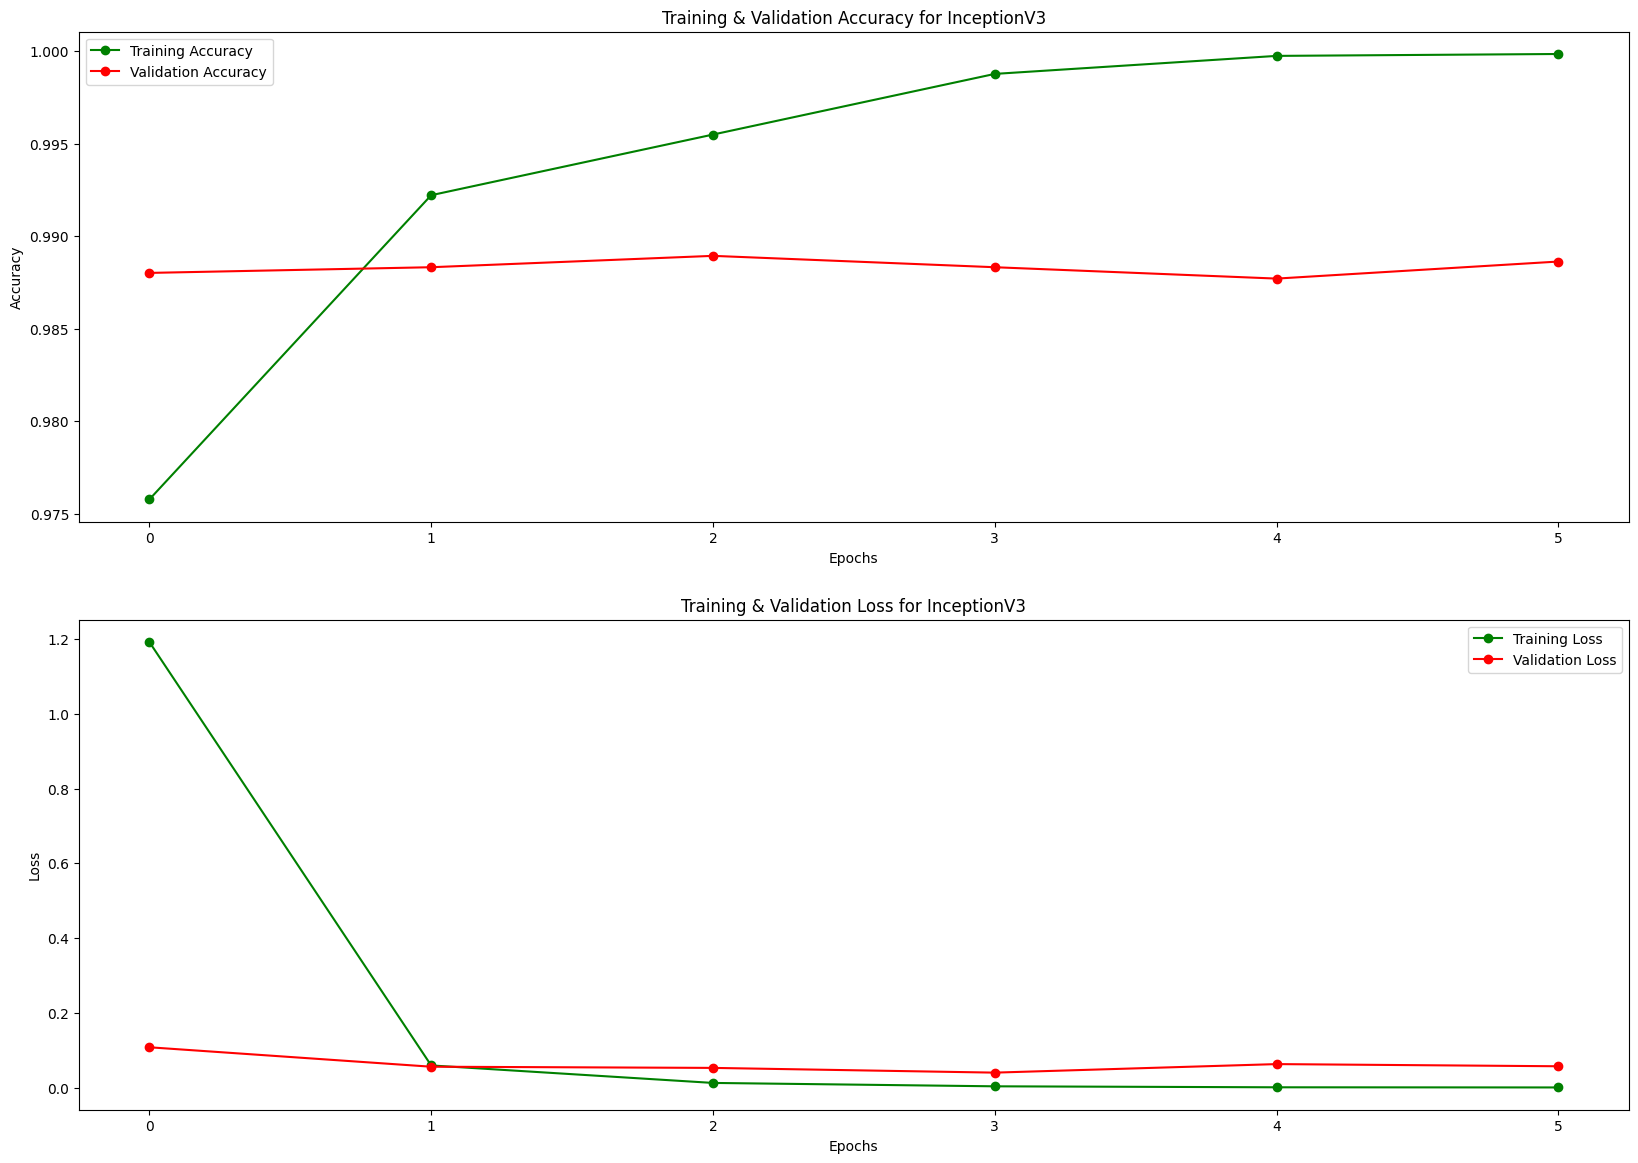

In [143]:
plot_accuracy_lost(hist9)

Tampak tidak ada overfitting

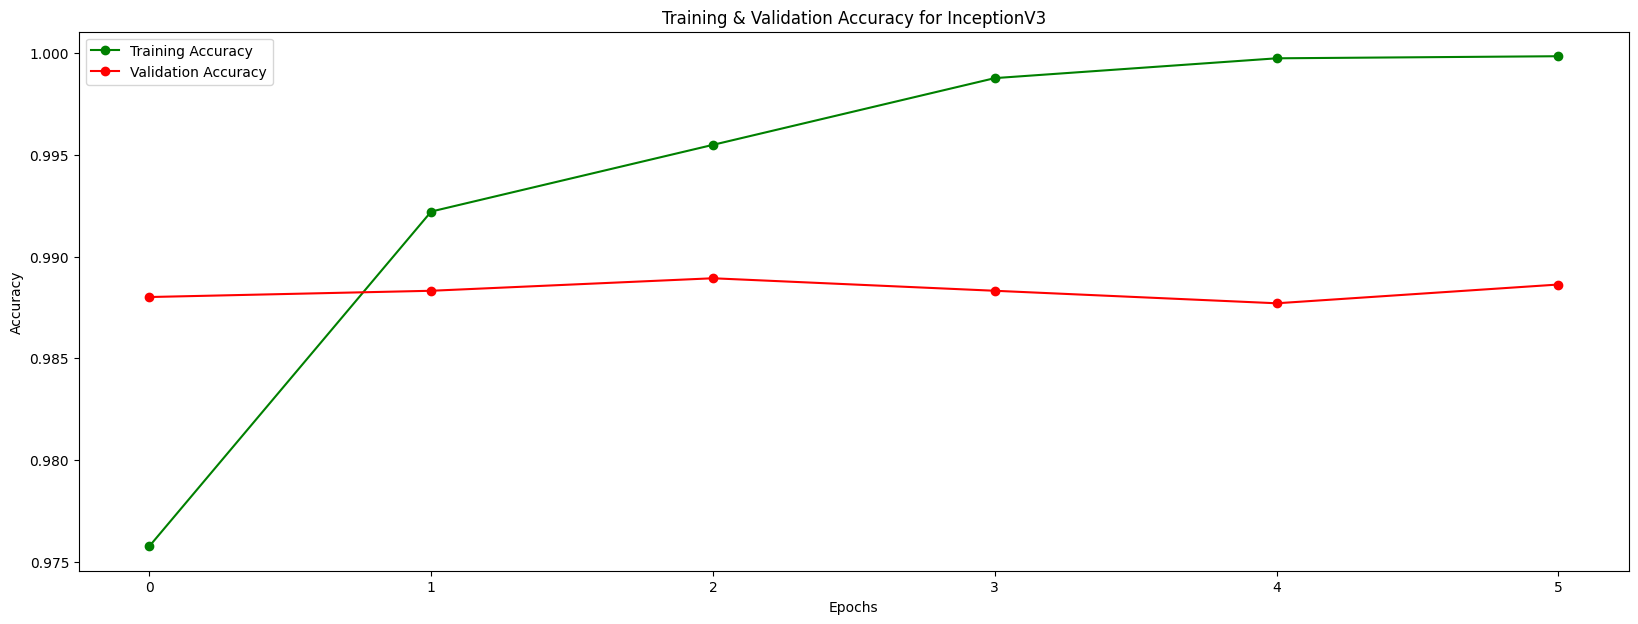

In [139]:
plt.figure(figsize=(20, 7))
i_train_acc = hist9.history['accuracy']
i_val_acc = hist9.history['val_accuracy']
i_epoch = [i for i in range(len(i_val_acc))]
plt.plot(i_epoch , i_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for InceptionV3')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [118]:
results_tabel = pd.DataFrame(hist9.history)
results_tabel.tail()

loss  accuracy  val_loss  val_accuracy
1  0.059516  0.992212  0.056105      0.988319
2  0.012734  0.995491  0.052930      0.988933
3  0.003683  0.998770  0.040278      0.988319
4  0.001067  0.999744  0.063094      0.987704
5  0.000650  0.999846  0.057313      0.988626

Menampilkan hasil prediksi

1/1 [==============================] - 0s 56ms/step


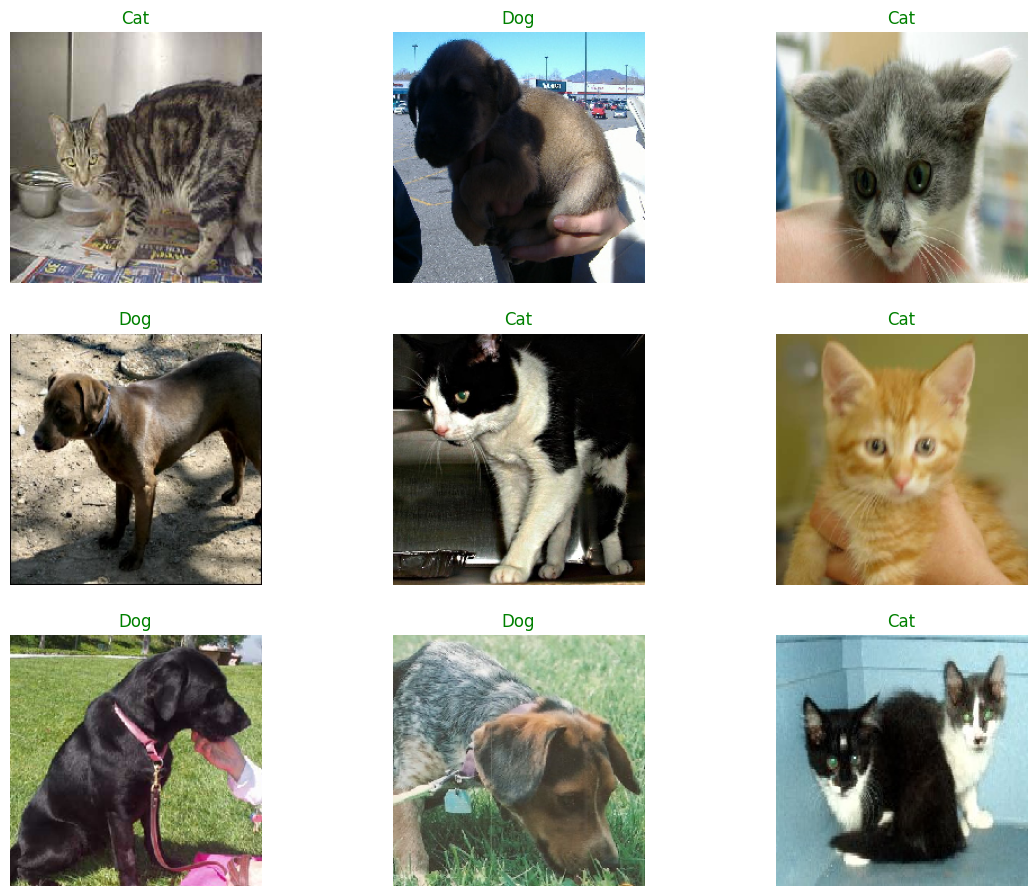

In [116]:
plot_prediction(model9, test_data, 10)

Tampak bahwa model berhasil memprediksi dengan benar

In [115]:
# Menyimpan model inceptionV3
model9.save(os.path.join("./models", "inceptionV3.h5"))

## **Memvisualisasikan Akurasi dari 3 Model Tersebut**

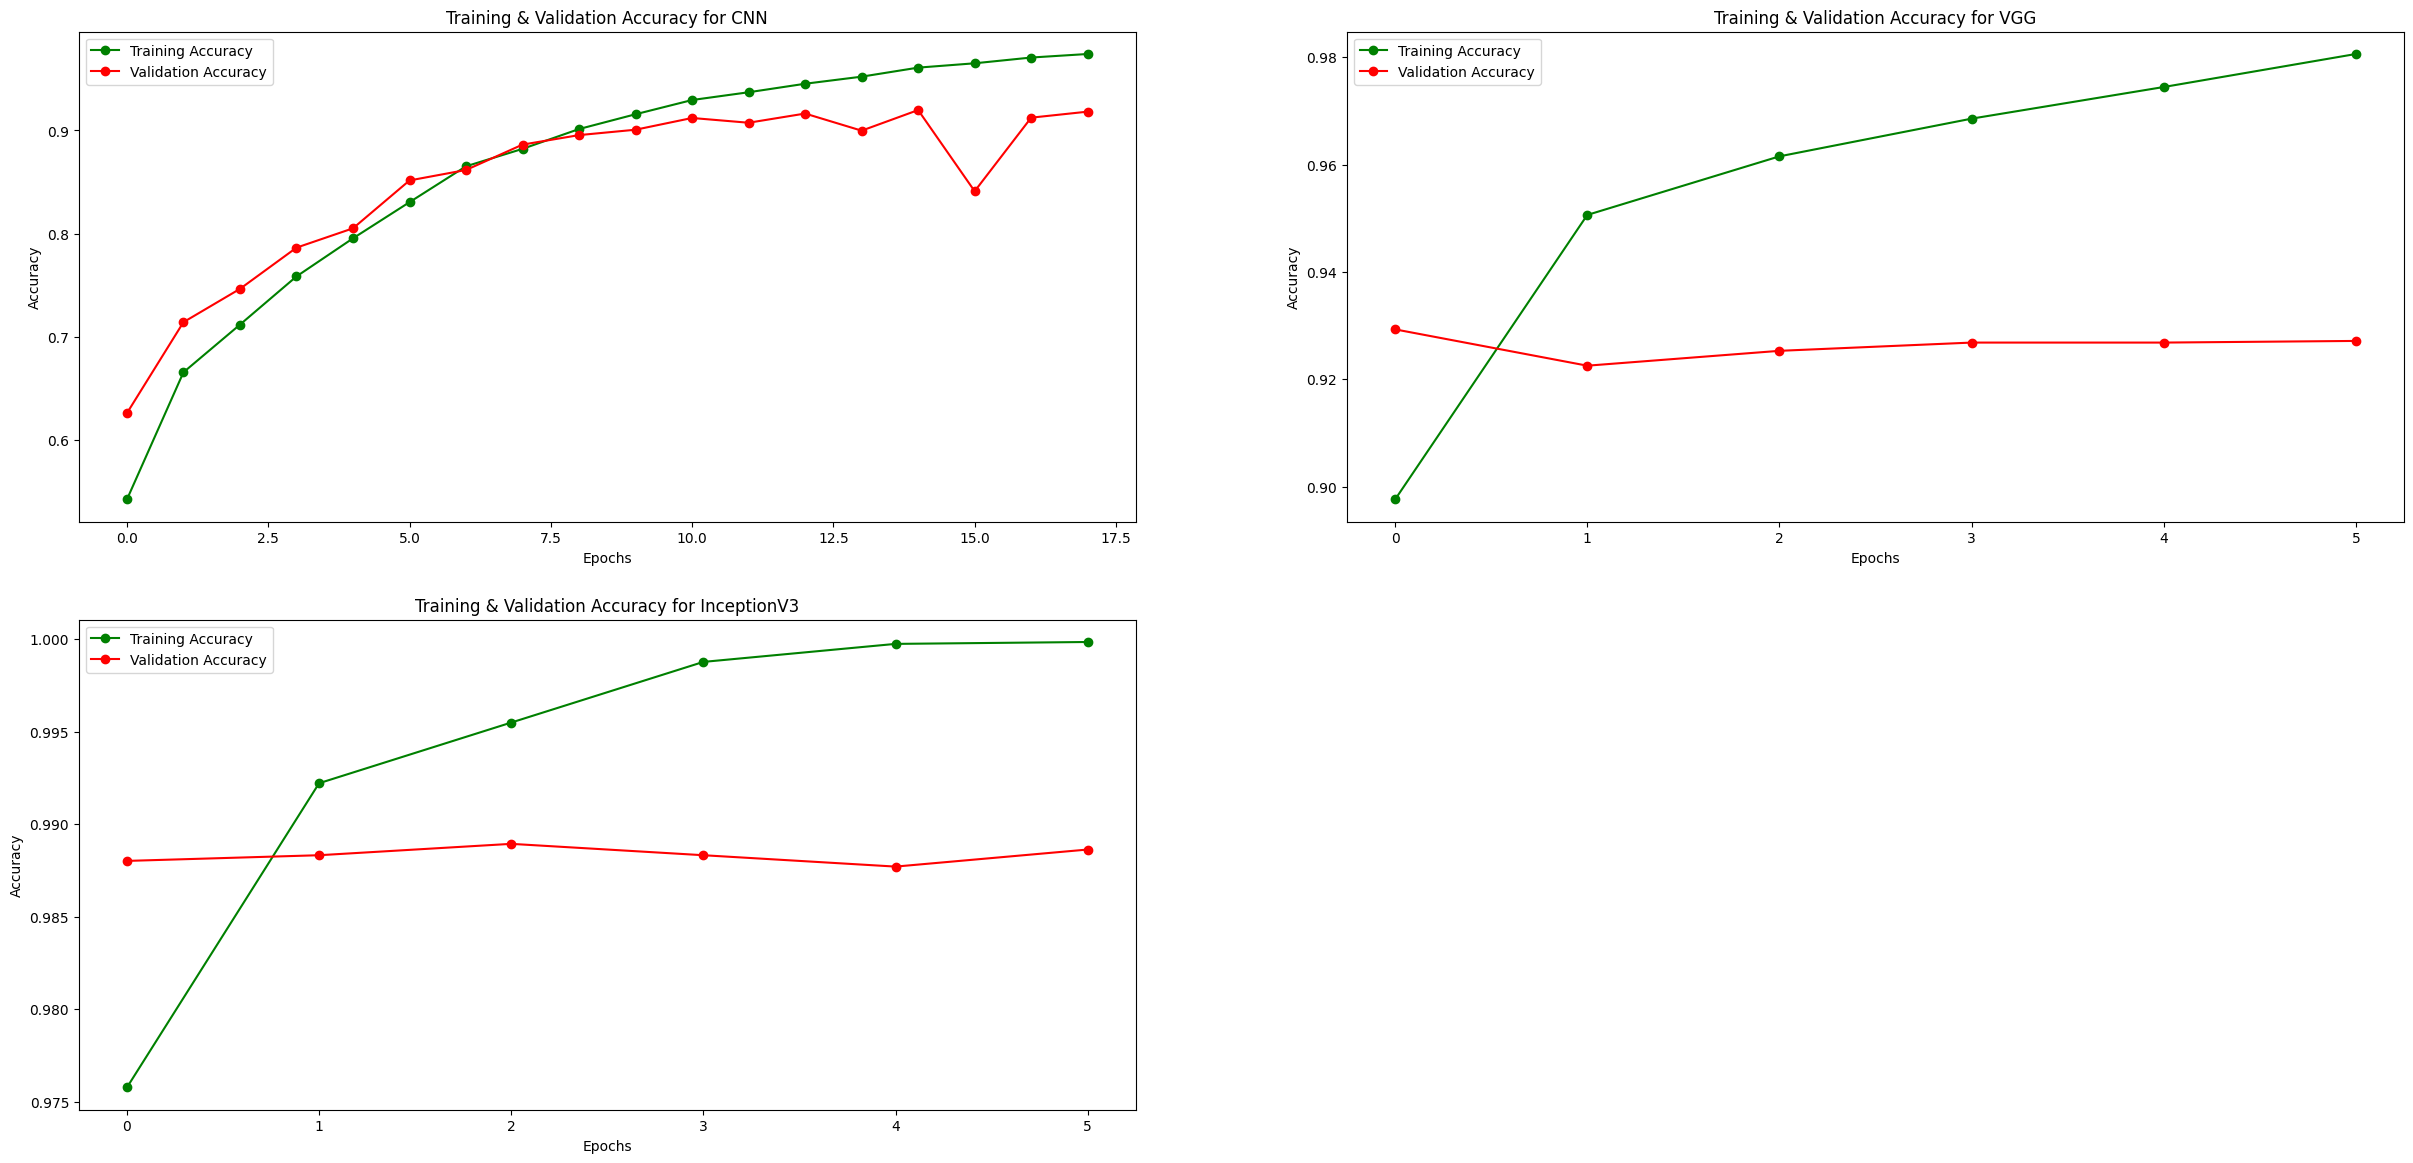

In [149]:
plt.figure(figsize = (30,14))

# Plot CNN
plt.subplot(2,2,1)
i_train_acc = hist5.history['accuracy']
i_val_acc = hist5.history['val_accuracy']
i_epoch = [i for i in range(len(i_val_acc))]
plt.plot(i_epoch , i_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for CNN')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Plot VGG
plt.subplot(2,2,2)
x_train_acc = hist7.history['accuracy']
x_val_acc = hist7.history['val_accuracy']
x_epoch = [i for i in range(len(x_val_acc))]
plt.plot(x_epoch , x_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(x_epoch , x_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for VGG')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Plot InceptionV3
plt.subplot(2,2,3)
x_train_acc = hist9.history['accuracy']
x_val_acc = hist9.history['val_accuracy']
x_epoch = [i for i in range(len(x_val_acc))]
plt.plot(x_epoch , x_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(x_epoch , x_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for InceptionV3')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()

Note: ketika membaca grafik, pastikan untuk membaca angka pada sumbu y nya karena angka pada sumbu y berbeda-beda

## **Kesimpulan**

Ketiga model tersebut tidak ada yang overfitting

**Akurasi terbaik didapatkan oleh model InceptionV3 dengan akurasi data validation dan data test yang mencapai 98.8%**